### PyWren RISECamp, 2017

In [73]:
%pylab inline
import boto3
import cloudpickle
import itertools
import concurrent.futures as fs
import io
import numpy as np
import time

Populating the interactive namespace from numpy and matplotlib


Welcome to the hands-on tutorial for PyWren.

This tutorial consists of a set of exercises that will have you working directly with PyWren:
- simple matrix multiplication
- data analysis on a wikipedia dataset
- some machine learning algorithms (Eric's) 


## 0. Hello World

First, let's write a simple hello program to test out PyWren.



In [2]:
# first we need to load PyWren and creates an executor instance
import pywren
pwex = pywren.default_executor()

We can use the `call_async()` API on pywren executor to run the function in the cloud
The workflow is pretty simple and looks like this:

```python
def my_func(param):
    # do something
    return some_result
    
handler = pwex.call_async(my_func, param)
result = handler.result()
```

**Exercise**: modify the following code block to run hello world with pywren

**TODO: I think we need helper function to test against the output. This gives attendees more incentive to get things right.**

In [7]:
# first we need a basic hello world function
def hello_world(param):
    return "hello world!"

handler = pwex.call_async(hello_world, 0) 
# on success, this line should print out "hello world"
print(handler.result())

hello world!


The above example runs a single function in the cloud.
Now PyWren also has a `map()` API that allows users to run a single function with multiple parameters:

```python
handlers = pwex.map(my_func, param_list)
pywren.wait(handlers)

results = [h.result() for h in handlers]
```

**Exercise**: modify the following code block to print "hello world"

In [ ]:
# do not modify code here
def hello_world(param):
    if param == 1:
        return "hello"
    if param == 2:
        return "world!"
# do not modify code above

param_list = []
handlers = pwex.call_async(hello_world, None)

results = [h.result() for h in handlers] 
print(" ".join(results))

## 1. Matrix Multiplication

One nice thing about PyWren is it allows users to integrate existing python libraries easily.
For the following exercise, we are going to use some popular python libraries, e.g., NumPy, to work on some matrix multiplication problems.

In [ ]:
import numpy as np

def my_function(b):
    x = np.random.normal(0, b, 1024)
    A = np.random.normal(0, b, (1024, 1024))
    return np.dot(A, x)

pwex = pywren.default_executor()
res = pwex.map(my_function, np.linspace(0.1, 10, 100))


## 2. Data Analytics with Wikipedia Dataset

## 3. Some Machine Learning

In [83]:
def list_all_keys(bucket, prefix):
    client = boto3.client('s3')
    objects = client.list_objects(Bucket=bucket, Prefix=prefix, Delimiter=prefix)
    keys = list(map(lambda x: x['Key'], objects['Contents']))
    truncated = objects['IsTruncated']
    next_marker = objects.get('NextMarker')
    while (truncated):
        objects = client.list_objects(Bucket=bucket, Prefix=prefix, Delimiter=prefix, Marker=next_marker)
        truncated = objects['IsTruncated']
        next_marker = objects.get('NextMarker')
        keys += list(map(lambda x: x['Key'], objects['Contents']))
    return list(filter(lambda x: len(x) > 0, keys))

def block_key_to_block(key):
    try:
        block_key = key.split("/")[-1]
        blocks_split = block_key.split("_")
        b0_start = int(blocks_split[0])
        b0_end = int(blocks_split[1])
        b1_start = int(blocks_split[3])
        b1_end = int(blocks_split[4])
        return ((b0_start, b0_end), (b1_start, b1_end))
    except:
        return None
    
class ShardedMatrix(object):
    def __init__(self, key,
                 shape=None,
                 shard_size_0=None,
                 shard_size_1=None,
                 bucket=None,
                 prefix='pywren.linalg/'):
        self.bucket = bucket
        self.prefix = prefix
        self.key = key
        self.key_base = prefix + self.key + "/"
        header = self.__read_header__()
        self.replication_factor = 1
        
        if header is None and shape is None:
            raise Exception("header doesn't exist and no shape provided")
        if not (header is None) and shape is None:
            self.shard_size_0 = header.shard_size_0
            self.shard_size_1 = header.shard_size_1
            self.shape = header.shape
        else:
            self.shape = shape
            self.shard_size_0 = shard_size_0
            self.shard_size_1 = shard_size_1

        if self.shard_size_0 is None:
            raise Exception("No shard_0_size provided")
        if self.shard_size_1 is None:
            self.shard_size_1 = self.shape[1]

        self.symmetric = False
        self.shard_sizes = (self.shard_size_0, self.shard_size_1)
        self.__write_header__()

    @property
    def blocks_exist(self):
        #slow
        prefix = self.prefix + self.key
        all_keys = list_all_keys(self.bucket, prefix)
        return list(filter(lambda x: x != None, map(block_key_to_block, all_keys)))

    @property
    def blocks(self):
        return self._blocks()

    @property
    def block_idxs_exist(self):
        all_block_idxs = self.block_idxs
        all_blocks = self.blocks
        blocks_exist = set(self.blocks_exist)
        block_idxs_exist = []
        for i, block in enumerate(all_blocks):
            if block in blocks_exist:
                block_idxs_exist.append(all_block_idxs[i])
        return block_idxs_exist

    @property
    def blocks_not_exist(self):
        blocks = set(self.blocks)
        block_exist = set(self.blocks_exist)
        return list(filter(lambda x: x, list(block_exist.symmetric_difference(blocks))))

    @property
    def block_idxs_not_exist(self):
        block_idxs = set(self.block_idxs)
        block_idxs_exist = set(self.block_idxs_exist)
        return list(filter(lambda x: x, list(block_idxs_exist.symmetric_difference(block_idxs))))




    @property
    def block_idxs(self):
        return self._block_idxs()

    def _blocks(self, axis=None):

        blocks_x = [(i, i + self.shard_size_0) for i in range(0, self.shape[0], self.shard_size_0)]

        if blocks_x[-1][1] > self.shape[0]:
            blocks_x.pop()

        if blocks_x[-1][1] < self.shape[0]:
            blocks_x.append((blocks_x[-1][1], self.shape[0]))


        blocks_y = [(i, i + self.shard_size_1) for i in range(0, self.shape[1], self.shard_size_1)]

        if blocks_y[-1][1] > self.shape[1]:
            blocks_y.pop()

        if blocks_y[-1][1] < self.shape[1]:
            blocks_y.append((blocks_y[-1][1], self.shape[1]))

        if axis is None:
            return list(itertools.product(blocks_x, blocks_y))
        elif axis == 0:
            return blocks_x
        elif axis == 1:
            return blocks_y
        else:
            raise Exception("Invalid Axis")

    def _block_idxs(self, axis=None):
        blocks_x = list(range(len(self._blocks(axis=0))))
        blocks_y = list(range(len(self._blocks(axis=1))))

        if axis is None:
            return list(itertools.product(blocks_x, blocks_y))
        elif axis == 0:
            return blocks_x
        elif axis == 1:
            return blocks_y
        else:
            raise Exception("Invalid Axis")

    def idx_to_block_idx(self, idx_1, idx_2):
        blocks_x = self._blocks(0)
        blocks_y = self._blocks(1)

        block_x = -1
        block_y = -1

        for i, (blk_start, blk_end) in enumerate(blocks_x):
            if blk_start <= idx_1 and blk_end > idx_1:
                block_x = i
                offset_x = idx_1 - blk_start

        for i, (blk_start, blk_end) in enumerate(blocks_y):
            if blk_start <= idx_2 and blk_end > idx_2:
                block_y = i
                offset_y = idx_2 - blk_start

        if block_x == -1:
            raise Exception("Index 0 out of bounds")

        if block_y == -1:
            raise Exception("Index 1 out of bounds")

        return block_x, block_y, offset_x, offset_y


    def __getitem__(self, idxs):
        idx_1, idx_2 = idxs

        if isinstance(idx_1, slice):
            raise Exception("Slicing in first index not implemented")

        if isinstance(idx_2, slice):
            if idx_2.start != None or idx_2.step != None or idx_2.stop != None:
                raise Exception("Only full row slices supported")
            blocks_y_idxs = self._block_idxs(axis=1)
            blocks = []
            block_x, block_y, offset_x, offset_y = self.idx_to_block_idx(idx_1, 0)
            for blk_idx in blocks_y_idxs:
                blocks.append(self.get_block(block_x, blk_idx))
            return np.hstack(blocks)[offset_x, :]

        else:
            block_x, block_y, offset_x, offset_y = self.idx_to_block_idx(idx_1, idx_2)
            block_data = self.get_block(block_x, block_y)
            return block_data[offset_x, offset_y]

    def __get_matrix_shard_key__(self, start_0, end_0, start_1, end_1, replicate=0):
            rep = str(replicate)
            key_string = "{0}_{1}_{2}_{3}_{4}_{5}_{6}".format(start_0, end_0, self.shard_size_0, start_1, end_1, self.shard_size_1, rep)
            return self.key_base + key_string



    def __read_header__(self):
        client = boto3.client('s3')
        try:
            key = self.key_base + "header"
            header = cloudpickle.loads(client.get_object(Bucket=self.bucket, Key=key)['Body'].read())
        except:
            header = None
        return header


    def __write_header__(self):
        client = boto3.client('s3')
        key = self.key_base + "header"
        client.put_object(Key=key, Bucket = self.bucket, Body=cloudpickle.dumps(self), ACL="bucket-owner-full-control")
        return 0

    def __shard_idx_to_key__(self, shard_0, shard_1, replicate=0):
        N = self.shape[0]
        D = self.shape[1]
        start_0 = shard_0*self.shard_size_0
        start_1 = shard_1*self.shard_size_1
        end_0 = min(start_0+self.shard_size_0, N)
        end_1 = min(start_1+self.shard_size_1, D)
        key = self.__get_matrix_shard_key__(start_0, end_0, start_1, end_1, replicate)
        return key

    def __s3_key_to_byte_io__(self, key):
        n_tries = 0
        max_n_tries = 5
        bio = None
        client = boto3.client('s3')
        while bio is None and n_tries <= max_n_tries:
            try:
                bio = io.BytesIO(client.get_object(Bucket=self.bucket, Key=key)['Body'].read())
            except Exception as e:
                n_tries += 1
        if bio is None:
            raise Exception("S3 Read Failed")
        return bio

    def __save_matrix_to_s3__(self, X, out_key, client=None):
        if (client == None):
            client = boto3.client('s3')
        outb = io.BytesIO()
        np.save(outb, X)
        response = client.put_object(Key=out_key, Bucket=self.bucket, Body=outb.getvalue(),ACL="bucket-owner-full-control")
        return response

    def shard_matrix(self, X, executor=None, n_jobs=1):
        bidxs = self.block_idxs
        blocks = self.blocks
        if (executor is None):
            executor = fs.ThreadPoolExecutor(n_jobs)

        futures = []
        print(blocks)
        for ((bidx_0, bidx_1),(block_0, block_1)) in zip(bidxs, blocks):
            bstart_0, bend_0 = block_0
            bstart_1, bend_1 = block_1
            future = executor.submit(self.put_block, bidx_0, bidx_1, X[bstart_0:bend_0, bstart_1:bend_1])
            futures.append(future)
        fs.wait(futures)
        [f.result() for f in futures]
        return 0


    def get_block(self, block_0, block_1, client=None, flip=False):
        client = boto3.client('s3')
        if (flip):
            block_0, block_1 = block_1, block_0
        s = time.time()
        r = np.random.choice(self.replication_factor, 1)[0]
        key = self.__shard_idx_to_key__(block_0, block_1, r)
        bio = self.__s3_key_to_byte_io__(key)
        e = time.time()
        s = time.time()
        X_block = np.load(bio)
        e = time.time()
            
        if (flip):
            X_block = X_block.T
        return X_block

    def put_block(self, block_0, block_1, block):

        start_0 = block_0*self.shard_size_0
        end_0 = min(block_0*self.shard_size_0 + self.shard_size_0, self.shape[0])
        shape_0 = end_0 - start_0

        start_1 = block_1*self.shard_size_1
        end_1 = min(block_1*self.shard_size_1 + self.shard_size_1, self.shape[1])
        shape_1 = end_1 - start_1


        if (block.shape != (shape_0, shape_1)):
            raise Exception("Incompatible block size: {0} vs {1}".format(block.shape, (shape_0,shape_1)))

        for i in range(self.replication_factor):
            key = self.__get_matrix_shard_key__(start_0, end_0, start_1, end_1, i)
            self.__save_matrix_to_s3__(block, key)


    def delete_block(self, block_0, block_1):
        client = boto3.client('s3')

        start_0 = block_0*self.shard_size_0
        end_0 = min(block_0*self.shard_size_0 + self.shard_size_0, self.shape[0])
        shape_0 = end_0 - start_0

        start_1 = block_1*self.shard_size_1
        end_1 = min(block_1*self.shard_size_1 + self.shard_size_1, self.shape[1])
        shape_1 = end_1 - start_1

        deletions = []
        for i in range(self.replication_factor):
            key = self.__get_matrix_shard_key__(start_0, end_0, start_1, end_1, i)
            deletions.append(client.delete_object(Key=key, Bucket=self.bucket))
        return deletions


In [15]:
from sklearn.datasets import fetch_mldata

In [61]:
mnist = fetch_mldata('MNIST original', data_home="/tmp/")
X = mnist.data.astype('float32')

In [69]:
X_sharded = ShardedMatrix("mnist", bucket="vaishaalpywren", shape=X.shape, shard_size_0=4096)

In [63]:
X_sharded.shard_matrix(X, n_jobs=10)

[((0, 4096), (0, 784)), ((4096, 8192), (0, 784)), ((8192, 12288), (0, 784)), ((12288, 16384), (0, 784)), ((16384, 20480), (0, 784)), ((20480, 24576), (0, 784)), ((24576, 28672), (0, 784)), ((28672, 32768), (0, 784)), ((32768, 36864), (0, 784)), ((36864, 40960), (0, 784)), ((40960, 45056), (0, 784)), ((45056, 49152), (0, 784)), ((49152, 53248), (0, 784)), ((53248, 57344), (0, 784)), ((57344, 61440), (0, 784)), ((61440, 65536), (0, 784)), ((65536, 69632), (0, 784)), ((69632, 70000), (0, 784))]


0

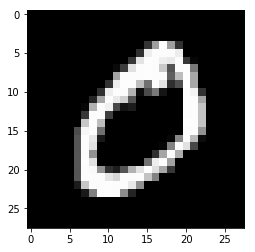

In [75]:
imshow(X_sharded.get_block(0,0)[0].astype('uint8').reshape(28,28), cmap=plt.cm.gray)

In [98]:
def xyt(x,y, z, blocks):
    block0, block1 = blocks
    submatrix_0 = x.get_block(block0, 0)
    submatrix_1 = y.get_block(block1, 0)
    out_matrix = submatrix_0.dot(submatrix_1.T)
    z.put_block(block0, block1, out_matrix)
    return 0


x_sharded = ShardedMatrix("mnist", bucket="vaishaalpywren", shape=X.shape, shard_size_0=4096)
xxt_sharded = ShardedMatrix("xxt(mnist)", bucket="vaishaalpywren", shape=(X.shape[0], X.shape[0]), shard_size_0=4096, shard_size_1=4096)

pwex = pywren.default_executor()

futures0 = pwex.map(lambda a: xyt(x_sharded, x_sharded, xxt_sharded, a), xxt_sharded.block_idxs_not_exist)


In [99]:
pywren.wait(futures0)

{'runtime_s3_bucket_used': 'ericmjonas-public', 'exception': "('OUTATIME', 'Process executed for too long and was killed')", 'data_download_time': 1.1064419746398926, 'runtime_s3_key_used': '87950c-pywren.runtime/pywren_runtime-3.6-default.tar.gz.0029', 'setup_time': 1.1704049110412598, 'start_time': 1504215004.511989, 'callset_id': 'c776b7e3-d46a-4d40-894e-41d79462d031', 'func_key': ['vaishaalpywren', 'pywren.jobs/c776b7e3-d46a-4d40-894e-41d79462d031/func.json'], 'call_id': '00234', 'status_key': ['vaishaalpywren', 'pywren.jobs/c776b7e3-d46a-4d40-894e-41d79462d031/00234/status.json'], 'func_download_time': 1.013772964477539, 'exception_traceback': 'Traceback (most recent call last):\n  File "/var/task/wrenhandler.py", line 299, in generic_handler\n    "Process executed for too long and was killed")\nException: (\'OUTATIME\', \'Process executed for too long and was killed\')\n', 'output_key': ['vaishaalpywren', 'pywren.jobs/c776b7e3-d46a-4d40-894e-41d79462d031/00234/output.pickle'], 'e

([<pywren.future.ResponseFuture at 0x149fe1eb8>,
 [])

In [100]:
[f.result() for f in futures0]

{'runtime_s3_bucket_used': 'ericmjonas-public', 'exception': "('OUTATIME', 'Process executed for too long and was killed')", 'data_download_time': 1.1064419746398926, 'runtime_s3_key_used': '87950c-pywren.runtime/pywren_runtime-3.6-default.tar.gz.0029', 'setup_time': 1.1704049110412598, 'start_time': 1504215004.511989, 'callset_id': 'c776b7e3-d46a-4d40-894e-41d79462d031', 'func_key': ['vaishaalpywren', 'pywren.jobs/c776b7e3-d46a-4d40-894e-41d79462d031/func.json'], 'call_id': '00234', 'status_key': ['vaishaalpywren', 'pywren.jobs/c776b7e3-d46a-4d40-894e-41d79462d031/00234/status.json'], 'func_download_time': 1.013772964477539, 'exception_traceback': 'Traceback (most recent call last):\n  File "/var/task/wrenhandler.py", line 299, in generic_handler\n    "Process executed for too long and was killed")\nException: (\'OUTATIME\', \'Process executed for too long and was killed\')\n', 'output_key': ['vaishaalpywren', 'pywren.jobs/c776b7e3-d46a-4d40-894e-41d79462d031/00234/output.pickle'], 'e

Exception: process ran out of time